In [214]:
import scipy
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy
import pandas
import sklearn
from sklearn import preprocessing
from sklearn import linear_model
import tensorflow

In [215]:
matlab_data = sio.loadmat(file_name='data/s2_sl2p_weiss_or_prosail_inout.mat', variable_names=['Input', 'Output'])

In [216]:
input_reflectances = pandas.DataFrame(data=matlab_data['Input']['Rho_Toc'][0][0])
input_angles = pandas.DataFrame(data=matlab_data['Input']['Angles'][0][0])

inputs = pandas.concat([input_reflectances, input_angles], axis=1, join='outer', ignore_index=True)
inputs = pandas.DataFrame(sklearn.preprocessing.scale(inputs))
features = ['B3', 'B4', 'B5', 'B6', 'B7', 'B8A', 'B11', 'B12', 'A1', 'A2', 'A3']
inputs.columns = features

In [217]:
LAI = pandas.Series(data=matlab_data['Output']['LAI'][0][0].flatten(), name="LAI")
FAPAR = pandas.Series(data=matlab_data['Output']['FAPAR'][0][0].flatten(), name="FAPAR")
FCOVER = pandas.Series(data=matlab_data['Output']['FCOVER'][0][0].flatten(), name="FCOVER")

In [218]:
num_samples = inputs.shape[0]
num_features = inputs.shape[1]

In [219]:
from sklearn.cluster import KMeans

In [220]:
# Should eventually be specifiable by the user
num_batches = 100

# Sets the number of clusters to a minimum of 100
num_clusters = max(100, num_samples/(num_batches*1000))

In [221]:
sample_clusters = KMeans(n_clusters=num_clusters).fit(inputs).labels_

In [222]:
input_data = inputs.join(LAI).join(FAPAR).join(FCOVER)

In [223]:
cluster_dictionary = input_data.groupby(sample_clusters).groups

In [224]:
import math

In [225]:
validation_split = 0.2
num_validation_clusters = int(math.ceil(num_clusters*validation_split))

In [226]:
import random

In [227]:
validation_clusters = random.sample(range(0, num_clusters), num_validation_clusters)

In [254]:
validation_dictionary = {cluster : cluster_dictionary[cluster] for cluster in validation_clusters}
validation_data = pandas.concat([input_data.loc[cluster] for cluster in validation_dictionary.values()], ignore_index=True)
num_validation_samples = len(validation_data)

In [229]:
calibration_clusters = list(set(range(0, num_clusters)) - set(validation_clusters))
calibration_dictionary = {cluster : cluster_dictionary[cluster] for cluster in calibration_clusters}
calibration_data = pandas.concat([input_data.loc[cluster] for cluster in calibration_dictionary.values()], ignore_index=True)
num_calibration_samples = len(calibration_data)

In [248]:
training_data = calibration_data[features].values
training_targets = calibration_data.LAI.values

In [256]:
validation_set = (validation_data[features].values, validation_data.LAI.values)

In [258]:
def tansig(x):
    return (2 / (1 + tensorflow.keras.backend.exp(-2*x)) ) - 1

In [259]:
tensorflow.keras.utils.get_custom_objects()['tansig'] = tensorflow.keras.layers.Activation(tansig)

In [260]:
# Using Keras to create a sequential model neural network which only has simple dense layers of the specified number of nodes
SL2P_model = tensorflow.keras.models.Sequential([
    tensorflow.keras.layers.Dense(11, input_shape = [num_features]),
    tensorflow.keras.layers.Dense(5, activation='tansig'),
    tensorflow.keras.layers.Dense(1)
])
# Compiling the model to minimize the mean squared error loss function and use the NADAM optimizer
SL2P_model.compile(
    optimizer=tensorflow.keras.optimizers.Nadam(),
    loss='mse')

In [262]:
early_stopping = tensorflow.keras.callbacks.EarlyStopping(monitor="loss", min_delta=0.0001, patience=25, verbose=1, mode="min", restore_best_weights=True)
SL2P_model.fit(x=training_data, y=training_targets, batch_size=32, epochs=1000, verbose=1, callbacks=[early_stopping], shuffle=True, validation_data=validation_set)

Train on 32541 samples, validate on 8931 samples
Epoch 1/1000
32541/32541 [==============================] - 2s 70us/sample - loss: 3.9491 - val_loss: 1.2463
Epoch 2/1000
32541/32541 [==============================] - 1s 38us/sample - loss: 1.0590 - val_loss: 0.6386
Epoch 3/1000
32541/32541 [==============================] - 1s 40us/sample - loss: 0.6146 - val_loss: 0.4555
Epoch 4/1000
32541/32541 [==============================] - 1s 40us/sample - loss: 0.4625 - val_loss: 0.4127
Epoch 5/1000
32541/32541 [==============================] - 1s 40us/sample - loss: 0.4110 - val_loss: 0.3837
Epoch 6/1000
32541/32541 [==============================] - 1s 44us/sample - loss: 0.3816 - val_loss: 0.3576
Epoch 7/1000
32541/32541 [==============================] - 1s 43us/sample - loss: 0.3613 - val_loss: 0.3492
Epoch 8/1000
32541/32541 [==============================] - 2s 47us/sample - loss: 0.3483 - val_loss: 0.3402
Epoch 9/1000
32541/32541 [==============================] - 2s 51us/sample - lo

In [285]:
validation_split = 0.2
num_validation_clusters = int(math.ceil(num_clusters*validation_split))
num_cv_loops = 100
num_epochs_per_loop = 100

for loop in range(num_cv_loops):
    
    validation_clusters = random.sample(range(0, num_clusters), num_validation_clusters)
    
    validation_dictionary = {cluster : cluster_dictionary[cluster] for cluster in validation_clusters}
    validation_data = pandas.concat([input_data.loc[cluster] for cluster in validation_dictionary.values()], ignore_index=True)
    num_validation_samples = len(validation_data)
    
    calibration_clusters = list(set(range(0, num_clusters)) - set(validation_clusters))
    calibration_dictionary = {cluster : cluster_dictionary[cluster] for cluster in calibration_clusters}
    calibration_data = pandas.concat([input_data.loc[cluster] for cluster in calibration_dictionary.values()], ignore_index=True)
    num_calibration_samples = len(calibration_data)
    
    training_data = calibration_data[features].values
    training_targets = calibration_data.LAI.values
    
    validation_set = (validation_data[features].values, validation_data.LAI.values)

    early_stopping = tensorflow.keras.callbacks.EarlyStopping(monitor="loss", min_delta=0.0001, patience=10, verbose=1, mode="min", restore_best_weights=True)
    SL2P_model.fit(x=training_data, y=training_targets, batch_size=32, epochs=num_epochs_per_loop, verbose=2, callbacks=[early_stopping], shuffle=True, validation_data=validation_set)

Train on 33255 samples, validate on 8217 samples
Epoch 1/100
33255/33255 [==============================] - 1s 45us/sample - loss: 0.1849 - val_loss: 0.2034
Epoch 2/100
33255/33255 [==============================] - 1s 45us/sample - loss: 0.1851 - val_loss: 0.2071
Epoch 3/100
33255/33255 [==============================] - 2s 51us/sample - loss: 0.1844 - val_loss: 0.2048
Epoch 4/100
33255/33255 [==============================] - 3s 89us/sample - loss: 0.1850 - val_loss: 0.2253
Epoch 5/100
33255/33255 [==============================] - 3s 79us/sample - loss: 0.1846 - val_loss: 0.2061
Epoch 6/100
33255/33255 [==============================] - 3s 86us/sample - loss: 0.1851 - val_loss: 0.2124
Epoch 7/100
33255/33255 [==============================] - 3s 84us/sample - loss: 0.1854 - val_loss: 0.2198
Epoch 8/100
33255/33255 [==============================] - 2s 70us/sample - loss: 0.1852 - val_loss: 0.2097
Epoch 9/100
33255/33255 [==============================] - 2s 58us/sample - loss: 0.183

In [297]:
# Predicting our own input data to evaluate the performance (for now)
nnet_predictions = SL2P_model.predict(inputs.values).flatten()

In [306]:
xy_tf_LAI = numpy.vstack([LAI.values, nnet_predictions])

In [307]:
from scipy import stats

In [308]:
z_tf_LAI = stats.gaussian_kde(xy_tf_LAI)(xy_tf_LAI)

In [309]:
idx_tf_LAI = z_tf_LAI.argsort()
x_tf_LAI = LAI[idx_tf_LAI]
y_tf_LAI = nnet_predictions[idx_tf_LAI]
z_tf_LAI = z_tf_LAI[idx_tf_LAI]

In [310]:
from sklearn import metrics

In [311]:
rmse_tf_LAI = metrics.mean_squared_error(x_tf_LAI, y_tf_LAI, squared=False)

In [312]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'NNET LAI- RMSE: 0.4244723549159722')

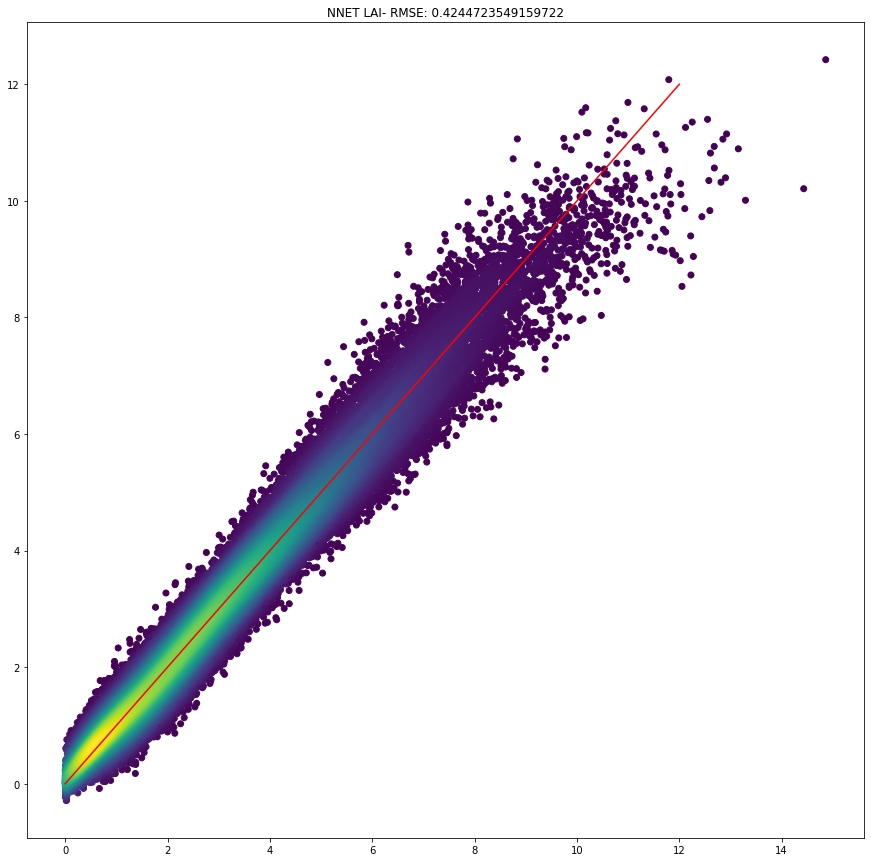

In [314]:
a_tf_LAI = numpy.linspace(0, 12, 1000)

fig, ax = plt.subplots(1, 1, figsize=(15,15))

ax.scatter(x_tf_LAI, y_tf_LAI, c=z_tf_LAI)
ax.plot(a_tf_LAI, a_tf_LAI, c='r')
ax.set_title('NNET LAI- RMSE: {}'.format(rmse_tf_LAI))

In [295]:
from sklearn.ensemble import RandomForestRegressor

In [296]:
regr = RandomForestRegressor()
regr.fit(inputs.values, LAI.values)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [315]:
rf_predictions = regr.predict(inputs.values)

In [316]:
xy_tf_LAI = numpy.vstack([LAI.values, rf_predictions])

In [317]:
from scipy import stats

In [318]:
z_tf_LAI = stats.gaussian_kde(xy_tf_LAI)(xy_tf_LAI)

In [319]:
idx_tf_LAI = z_tf_LAI.argsort()
x_tf_LAI = LAI[idx_tf_LAI]
y_tf_LAI = rf_predictions[idx_tf_LAI]
z_tf_LAI = z_tf_LAI[idx_tf_LAI]

In [320]:
from sklearn import metrics

In [321]:
rmse_tf_LAI = metrics.mean_squared_error(x_tf_LAI, y_tf_LAI, squared=False)

In [322]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'LASSO LARS FAPAR - RMSE: 0.23561734555282013')

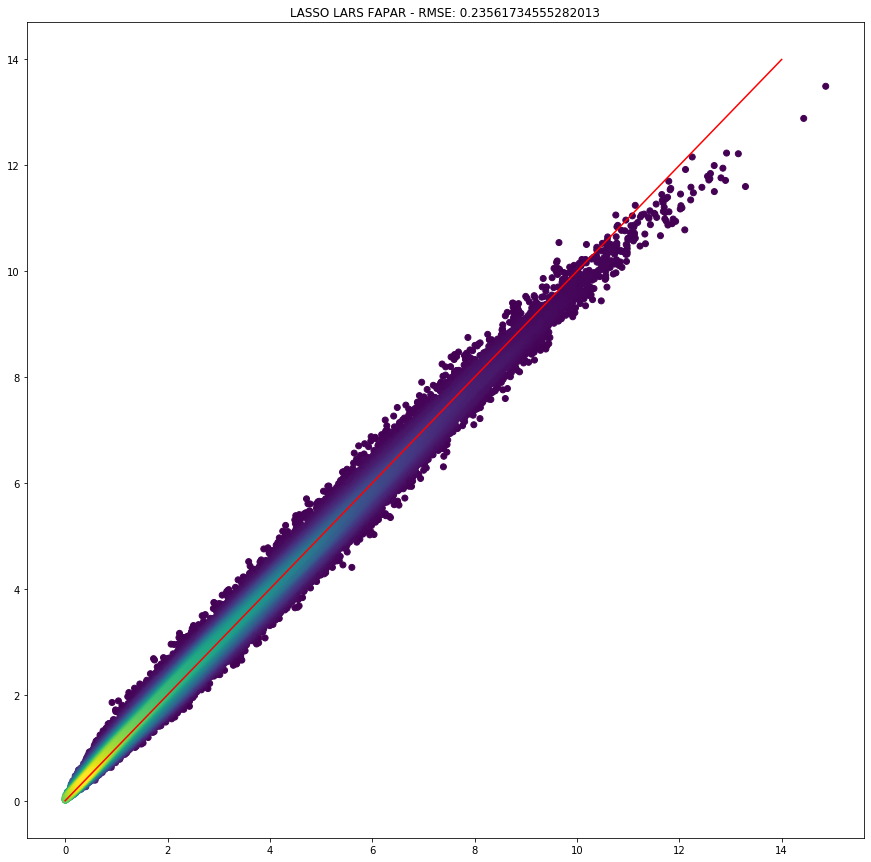

In [324]:
a_tf_LAI = numpy.linspace(0, 14, 1000)

fig, ax = plt.subplots(1, 1, figsize=(15,15))

ax.scatter(x_tf_LAI, y_tf_LAI, c=z_tf_LAI)
ax.plot(a_tf_LAI, a_tf_LAI, c='r')
ax.set_title('LASSO LARS FAPAR - RMSE: {}'.format(rmse_tf_LAI))

In [31]:
import ee

In [ ]:
ee.Initialize()

In [438]:
def nnet_to_ee(keras_model):
    neural_net = ee.List([])
    for layer in keras_model.layers:
        layer_info = layer.get_config()
        num_nodes = layer_info["units"]
        activation = layer_info["activation"]
        
        layer_weights = layer.get_weights()[0].transpose()
        layer_bias = layer.get_weights()[1].tolist()
        
        nodes = [ee.ImageCollection([ee.Image(weight) for weight in node.tolist()]).toBands() for node in layer_weights]
        node_collection = ee.ImageCollection(ee.List([ee.Image(nodes[i]).set({"bias": layer_bias[i]}) for i in range(num_nodes)])).set({"activation": activation})
        neural_net = neural_net.add(node_collection)
    
    return neural_net

In [439]:
neural_net = nnet_to_ee(SL2P_model)

In [446]:
# Defining all of the activation functions for image structures in Earth Engine
def linear(x):
    return ee.Image(x)

def elu(x):
    return ee.ImageCollection([x.mask(x.gte(0)), x.mask(x.lt(0)).exp().subtract(1)]).mosaic()

def softplus(x):
    return x.exp().add(1).log()

def softsign(x):
    return x.divide(x.abs().add(1))

def relu(x):
    return x.max(0.0)

def tanh(x):
    return x.multiply(2).exp().subtract(1).divide(x.multiply(2).exp().add(1))

def sigmoid(x):
    return x.exp().pow(-1).add(1).pow(-1)

In [447]:
# The following function applies a layer in the neural network as parsed in the parse_layer function to an input image with the selected features, and response.
# To fully apply the neural network we apply this function using the .iterate() method in Earth Engine on the input image in place of a loop
def apply_nnet(layer, inputs):
    layer = ee.ImageCollection(layer)
    inputs = ee.Image(inputs)
    
    activation = layer.getString("activation")

    def apply_node(node):
        node = ee.Image(node)
        bias = node.getNumber("bias")
        
        # Multiply by the weights of the node and add the bias of the node
        result = inputs.multiply(node).reduce(ee.Reducer.sum()).add(bias)
        # For now we can only apply the softsign activation function if the activation property of the layer is not "linear"
        return ee.Algorithms.If(activation.compareTo("linear"), relu(result), result)
    
    node_outputs = layer.map(apply_node).toBands()
    
    return node_outputs;

In [448]:
validation_data = <insertproductimage>.select("LAI")
nnet_inputs = <insertinputimage>.select(selected_features)
predictions = ee.Image(neural_net.iterate(apply_nnet, nnet_inputs)).rename("Predictions")

In [449]:
import folium

In [450]:
mapIdDict = prediction_data.getMapId()
map = folium.Map(location=[49.7, -97.9])
folium.TileLayer(
    tiles=mapIdDict['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='Predicted LAI',
  ).add_to(map)
map.add_child(folium.LayerControl())
map